# Supervised learning demo: what position do I play?

Last time I covered a section on clustering, a group of _unsupervised_ learning methods – so called because they are not given the class memberships of the data$^\dagger$. Don't worry, I will do more posts on clustering soon. For now I wanted to give a quick overview of what _supervised_ methods look like. For that, let's look at the statistics of hockey players!

$\dagger$: this is a gross generalisation. More formally, for some dataset $\mathbf{X}$, if we are trying to predict an output variable $\mathbf{Y}$, we use supervised learning methods, otherwise unsupervised learning methods.

Hockey (on ice, obviously!) is a game where we have 5 skaters and 1 goalie per rotation.
The 5 skaters can be divided into three$^\ddagger$ subclasses:
* The wingers (LW, RW)
* The centre (C)
* Defensemen (D)

$\ddagger$: the centre and wingers can also be bundled up as forwards.

![](hockey_players_position.png)

Typically, each skater's actions are recorded, which include:
* Goal(s) scored, assist(s) made [i.e. did the player make a pass leading up to the goal?]
* Penalties in minutes (infringements typically lead to 2 minute bans from the game)
* Ice time in 5-on-5 or 'penalty kill' situations
* Shots blocked
etc.

Usually by looking at these statistics, one can have an approximate idea of the position a given hockey player plays. To many, this might seem like a pretty easy problem. Surely forwards are supposed to score goals! Defensemen are supposed to block shots!

#### Wait, so why do you want to know a player's position?
Predicting a player's position is perhaps not the first classification that comes to mind. However, it's useful for something like fantasy sports leagues. In fantasy sports, you typically have roster slots for _n_ centres, _m_ defensemen, and _q_ wingers. Using those constraints, you want to (usually) maximise every statistical category.

For example, if a fantasy team has a bunch of goal-scoring centremen, which position player do we pick out next to max out the penalties in minutes category? Simultaneously, which position also happens to maximise the number of assists? Do we pick up a defenseman, or a gritty right wing?

Hockey is slightly more complex than meets the eye. Typically, being a defenseman or forward can largely constrain your statistical profile; there are some defensemen that are very talented on offense (e.g. Morgan Reilly), and some forwards who are tougher, and deployed on a "checking" line to provide strength.

![MR](https://imagesvc.timeincapp.com/v3/fan/image?url=https%3A%2F%2Feditorinleaf.com%2Fwp-content%2Fuploads%2Fgetty-images%2F2018%2F06%2F949930044.jpeg&c=sc&w=736&h=485)

(This is Morgan Reilly.)

So, how can we predict positions using stats? Let's find out.

**If you have 30 seconds...**
* This post is really a demo of various supervised learning methods. See table below for a quick overview.
* The algorithm of choice is often dependent on use case, and you should consider questions like:
    * What is the distribution of your output?
    * How can we interpret the model?
    
**If you have 10 minutes...**
* Read on. I've tried to section this entry based on what bits you might be interested in. This post is very much intended to be a whirlwind tour of the various supervised learning methods, rather than a deep-dive.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data cleanup

In [2]:
# Read in the data from Kaggle
df = pd.read_csv("/Users/jleem/dev/personal-website/assets/data/hockey/game_skater_stats.csv")

# We'll use this later.
pinfo = pd.read_csv("/Users/jleem/dev/personal-website/assets/data/hockey/player_info.csv")

In [3]:
df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,0,0,0,0,0,0,-1,885,98,16
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,0,1,1,0,0,1,0,767,401,0
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,2,0,0,0,0,1,-1,542,0,16
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,0,1,0,0,0,1,-1,935,183,16
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,6,0,0,0,0,0,-1,436,0,0


The skater stats are given per player (`player_id`), and per game (`game_id`) that they have played. We know from some good documentation that:
* The first four digits represent the season (e.g. 2010-2011 season)
* The next two digits represent whether the game was held in the regular season or playoffs, etc.

What we will do is some clever `pandas` magic to:
* Only use regular season games
* Aggregate the statistics per player

In [4]:
# Filter for regular season and annotate season ID
# https://github.com/dword4/nhlapi#game-ids

df['game_id'] = df['game_id'].astype(str)
reg_season = df[df['game_id'].apply(lambda x: x[4:6] == "02")].copy()
reg_season['Season'] = reg_season['game_id'].apply(lambda x: x[:4])

In [5]:
reg_season.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,Season
25379,2013020674,8471817,19,547,0,0,1,6,0,0,...,1,1,0,0,0,-1,547,0,0,2013
25380,2013020674,8467890,19,1103,0,0,0,0,0,0,...,2,0,0,0,0,-1,999,104,0,2013
25381,2013020674,8475768,19,1119,0,0,4,1,0,0,...,0,0,0,0,0,0,955,78,86,2013
25382,2013020674,8473534,19,1006,1,0,3,0,0,0,...,2,0,0,0,0,0,930,42,34,2013
25383,2013020674,8466160,19,593,0,0,0,3,0,0,...,0,0,0,0,0,-1,593,0,0,2013


In [6]:
# aggregate stats and use average for time; otherwise totals
# We could do this by season but we'll stick to overall totals for simplification.
aggregated_stats = reg_season.groupby('player_id').agg(
    {
        "game_id": len, # use this as an aggregating function to get number of games played
        "timeOnIce": "mean",
        "goals": "sum",
        "assists": "sum",
        "shots": "sum",
        "hits": "sum",
        "powerPlayGoals":"sum",
        "powerPlayAssists": "sum",
        "penaltyMinutes": "sum",
        "faceOffWins": "sum",
        "faceoffTaken": "sum",
        "takeaways": "sum",
        "giveaways": "sum",
        "shortHandedGoals": "sum",
        "shortHandedAssists": "sum",
        "blocked": "sum",
        "plusMinus": "sum",
        "evenTimeOnIce": "mean",
        "shortHandedTimeOnIce": "mean",
    }
)
aggregated_stats.columns = ['games_played'] + list(aggregated_stats.columns[1:])
aggregated_stats

,games_played,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce
player_id,,,,,,,,,,,,,,,,,,,
8446485,47,626.978723,6,5,57,45,0,0,12,95,168,16,8,0,0,11,1,573.255319,51.191489
8448208,460,1039.756522,120,202,1041,114,36,48,260,2,8,199,276,0,0,73,47,872.436957,1.308696
8449645,40,746.900000,4,11,79,7,1,5,8,133,274,14,13,0,0,10,-4,594.250000,0.575000
8450725,81,966.283951,14,34,132,81,6,11,35,52,97,16,32,0,1,25,13,761.962963,43.308642
8455919,18,558.111111,2,0,11,21,0,0,8,101,189,4,10,0,0,10,-1,414.444444,140.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481442,1,760.000000,0,0,1,2,0,0,0,0,0,0,0,0,0,1,1,760.000000,0.000000
8481477,2,767.000000,0,0,7,3,0,0,0,5,17,0,0,0,0,2,0,717.000000,43.000000
8481479,2,801.000000,0,0,3,0,0,0,0,0,0,1,1,0,0,2,-1,801.000000,0.000000


Let's do some more feature engineering to make our lives easier...

In [7]:
# Powerplay and shorthanded goals/assists are typically much lower than regular goals/assists, so it's convenient to take the sum.
# Faceoffs are typically reported in percentages, anyway.
aggregated_stats['powerPlayPoints'] = aggregated_stats['powerPlayGoals'] + aggregated_stats['powerPlayAssists']
aggregated_stats['shortHandedPoints'] = aggregated_stats['shortHandedGoals'] + aggregated_stats['shortHandedAssists']

# Since some players never take faceOffs, just stick to 0 to avoid zero division errors
percentage = (aggregated_stats['faceOffWins'] / aggregated_stats['faceoffTaken'])*100
percentage = [ _ if not np.isnan(_) else 0 for _ in percentage ]

aggregated_stats['faceOffPercentage'] = percentage
aggregated_stats.drop(columns=['powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'faceOffWins', 'faceoffTaken'])

,games_played,timeOnIce,goals,assists,shots,hits,penaltyMinutes,takeaways,giveaways,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayPoints,shortHandedPoints,faceOffPercentage
player_id,,,,,,,,,,,,,,,,
8446485,47,626.978723,6,5,57,45,12,16,8,11,1,573.255319,51.191489,0,0,56.547619
8448208,460,1039.756522,120,202,1041,114,260,199,276,73,47,872.436957,1.308696,84,0,25.000000
8449645,40,746.900000,4,11,79,7,8,14,13,10,-4,594.250000,0.575000,6,0,48.540146
8450725,81,966.283951,14,34,132,81,35,16,32,25,13,761.962963,43.308642,17,1,53.608247
8455919,18,558.111111,2,0,11,21,8,4,10,10,-1,414.444444,140.055556,0,0,53.439153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481442,1,760.000000,0,0,1,2,0,0,0,1,1,760.000000,0.000000,0,0,0.000000
8481477,2,767.000000,0,0,7,3,0,0,0,2,0,717.000000,43.000000,0,0,29.411765
8481479,2,801.000000,0,0,3,0,0,1,1,2,-1,801.000000,0.000000,0,0,0.000000


Finally, for each player, if they have played fewer than 41 games, let's remove them. I chose the number 41 because
there are 82 games in a season. I want to know that a player has played at least half a season's worth of games, otherwise we would have very little data to work with.

In [8]:
sufficient_games = []
for n,g in aggregated_stats.groupby('player_id'):
    if g['games_played'].sum() >= 41:
        sufficient_games.append(n)

final_stats = aggregated_stats[aggregated_stats.index.get_level_values("player_id").isin(sufficient_games)].copy()
final_stats_players = final_stats.index.get_level_values('player_id')
final_stats

,games_played,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayPoints,shortHandedPoints,faceOffPercentage
player_id,,,,,,,,,,,,,,,,,,,,,
8446485,47,626.978723,6,5,57,45,0,0,12,95,...,8,0,0,11,1,573.255319,51.191489,0,0,56.547619
8448208,460,1039.756522,120,202,1041,114,36,48,260,2,...,276,0,0,73,47,872.436957,1.308696,84,0,25.000000
8450725,81,966.283951,14,34,132,81,6,11,35,52,...,32,0,1,25,13,761.962963,43.308642,17,1,53.608247
8456283,47,1075.510638,0,8,23,55,0,0,33,0,...,15,0,0,67,-9,896.234043,170.702128,0,0,0.000000
8457063,152,1416.460526,27,69,323,90,11,45,48,0,...,56,0,1,171,19,1049.921053,133.348684,56,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8480839,82,1269.329268,9,35,177,97,5,15,34,0,...,79,0,0,66,-13,1088.743902,9.500000,20,0,0.000000
8480943,53,840.905660,3,4,43,57,0,0,14,0,...,34,0,0,48,0,835.075472,4.113208,0,0,0.000000
8480944,65,680.800000,1,12,65,58,0,0,18,204,...,12,0,0,55,5,581.415385,95.230769,0,0,50.122850


In [9]:
final_stats.to_csv("/Users/jleem/dev/personal-website/assets/data/hockey/final-cleaned-stats.csv")

## Train, validate, test

In machine learning, training, validating, and testing your model is a fundamental piece of the puzzle. Without proper splits of your data, there is a potential to overfit your model to the training set. Furthermore, the split datasets should have similar distributions of classes so that you avoid overfitting/over-penalisation, too. For the sake of this blog, I will only split by training and testing, and make one split. There are other split strategies like $k$-fold cross-validation but... we won't talk about that for now. Back to topic!

Splitting is best done using `sklearn`'s builtin train-test splitter:

In [9]:
from sklearn.model_selection import train_test_split

# Get skater data from pinfo
skaters = pinfo[pinfo['primaryPosition'] != "G"][['player_id', 'firstName', 'lastName', 'primaryPosition']].copy()
skaters = skaters[skaters['player_id'].isin(final_stats_players)]

# the stratify argument makes sure we split our dataset
# so that even though the test set is 1/3 the size of the training set
# it has a similar distribution of wingers, defensemen... etc.
# let's use a seed of 0.
training_ids, test_ids = train_test_split(skaters['player_id'], random_state = 0,
                                               test_size = 0.25, stratify = skaters['primaryPosition'])

In [10]:
# get the training set of data.
# Since aggregated_stats is aggregated on both player id and season,
# we have a multi-index object. this is a way to search on one column of that index.
playerIdIndex = aggregated_stats.index.get_level_values("player_id")

# Get the training set and test set of data.
training_set = aggregated_stats[playerIdIndex.isin(training_ids)].copy()
test_set = aggregated_stats[playerIdIndex.isin(test_ids)].copy()
training_set.head(20)

,games_played,timeOnIce,goals,assists,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayPoints,shortHandedPoints,faceOffPercentage
player_id,,,,,,,,,,,,,,,,,,,,,
8448208,460,1039.756522,120,202,1041,114,36,48,260,2,...,276,0,0,73,47,872.436957,1.308696,84,0,25.000000
8450725,81,966.283951,14,34,132,81,6,11,35,52,...,32,0,1,25,13,761.962963,43.308642,17,1,53.608247
8456283,47,1075.510638,0,8,23,55,0,0,33,0,...,15,0,0,67,-9,896.234043,170.702128,0,0,0.000000
8457063,152,1416.460526,27,69,323,90,11,45,48,0,...,56,0,1,171,19,1049.921053,133.348684,56,1,0.000000
8458529,88,982.227273,18,21,172,21,7,5,50,4,...,70,0,0,13,-7,808.840909,6.965909,12,0,30.769231
8458537,258,1019.697674,61,134,527,81,18,55,70,66,...,155,0,0,55,21,812.027132,1.325581,73,0,39.285714
8458590,179,931.262570,34,32,325,185,8,10,88,28,...,36,1,1,87,-9,759.122905,67.363128,18,2,41.791045
8458938,163,1196.533742,7,41,194,143,2,13,123,0,...,99,0,0,355,13,1009.042945,101.754601,15,0,0.000000
8458943,65,1014.615385,12,27,116,64,3,9,24,17,...,28,0,0,30,5,819.969231,1.292308,12,0,45.945946


Normally for machine learning methods, we can do some form of _feature selection_ to use the most relevant variables. I am going to do the slightly naive approach of using every possible variable for prediction. This is something that may be done in practice, though it's not the most clever idea; variables can be correlated. Here I'm going to do what's called a "pairplot":

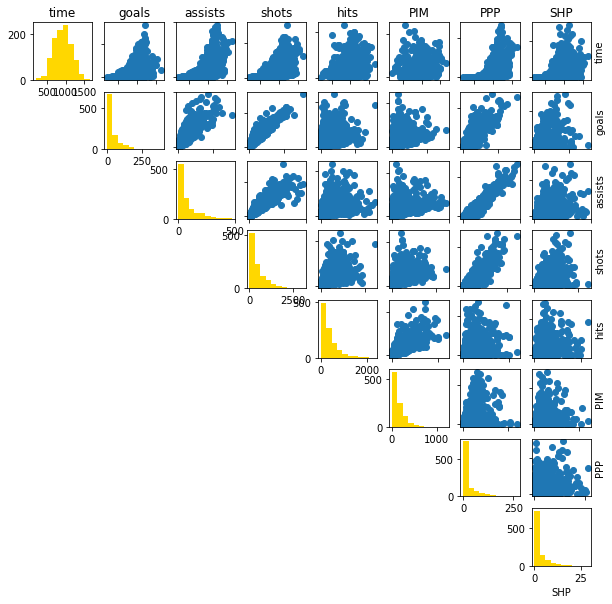

In [11]:
def pairplot(columns, names):
    n_col = columns.shape[1]
    fig, ax = plt.subplots(n_col, n_col)
    
    short_names = {
        'timeOnIce': "time", 
        'goals': "goals", 
        'assists': "assists", 
        'shots': "shots", 
        'hits': "hits", 
        'penaltyMinutes': "PIM", 
        'powerPlayPoints': "PPP", 
        'shortHandedPoints': "SHP"
    }
    
    # Upper-triangular matrix shows correlation between variables
    for i in range(0, n_col-1):
        for j in range(i+1, n_col):
            ax[i,j].scatter(columns[:,i], columns[:,j])
            if j - i > 0:
                ax[i,j].get_yaxis().set_ticklabels([])
                ax[i,j].get_xaxis().set_ticklabels([])
                
            if i == 0:
                ax[i,j].set_title("{}".format(short_names[names[j]]))
            if j == n_col-1:
                ax[i,j].yaxis.set_label_position("right")
                ax[i,j].set_ylabel("{}".format(short_names[names[i]]))

    # Diagonal contains histograms
    for i in range(0, n_col):
        for j in range(0, n_col):
            if i != j: continue
            ax[i,j].hist(columns[:,i], color = '#ffd700')
            
            if i == 0:
                ax[i,j].set_title("{}".format(short_names[names[j]]))
            elif j == (n_col-1):
                ax[i,j].set_xlabel("{}".format(short_names[names[j]]))
    
    # Lower-triangular matrix is hidden
    for i in range(1, n_col):
        for j in range(0, i):
            ax[i,j].axis("off")

    return fig, ax

columns = ['timeOnIce', 'goals', 'assists', 'shots', 'hits', 'penaltyMinutes', 'powerPlayPoints', 'shortHandedPoints']

fig, ax = pairplot(training_set[columns].values, columns)
fig.set_size_inches((10,10))

In [12]:
# Get the names of the players
train_skaters = skaters[skaters['player_id'].isin(training_ids)].copy()
test_skaters  = skaters[skaters['player_id'].isin(test_ids)].copy()

# Create a dictionary of player IDs to positions, this makes label creation easier
train_position = dict(train_skaters[['player_id','primaryPosition']].values)
test_position = dict(test_skaters[['player_id','primaryPosition']].values)


# Get "labels" which are the hockey players' positions.
train_labels = [train_position[pid] for pid in training_set.index.get_level_values('player_id')]
test_labels  = [test_position[pid] for pid in test_set.index.get_level_values('player_id')]

## The "ML bit"

For this exercise, I am going to use the following supervised learning methods; below is a summary along with some pros and cons of each method. I've also tried to write equations where appropriate.

* **Logistic Regression** – Applies the logistic (binary classes) or softmax (multiple) function to a linear combination of weighted variables to predict the probability of class membership.
    * Pros: Model is fairly simple to interpret, with flexibility for regularisation$\dagger$.
    * Cons: Assumes a linear relationship between features (after logistic transformation) to class membership
    * $$Pr(Y = c) = \dfrac{ e^{z_c}}{\sum_{i=1}^C e^{z_i} } ~~\mathrm{where}~~ z_i = w_iX+b_i.$$ 
* **Naive Bayes Classifier** – applies "Bayes' rule" to estimate the probability of belonging to a class.
    * Pros: Typically shows good performance and is inexpensive to run.
    * Cons: Assumes that each feature is independent of another
    * $$Pr(Y = c|x_1, x_2... x_n) \propto P(c) \prod_{i=1}^{C} Pr(x_i|c)$$
* **Random Forest Classifier** – bootstraps$\ddagger$ the dataset to create a series of decision trees (the "forest"). New data is then predicted according to all the decision trees, and we take the average prediction. In the case of classification, we take the majority vote.
    * Pros: Possible to trace the importance of specific features using the Gini index; very stable performance.
    * Cons: Difficult to trace how the decision trees were made.
    * For regression, $$\hat{f} = \dfrac{1}{T} \sum_{i=1}^{T} f_i(X_{test})$$
* **Support Vector machines** – finds a hyperplane that best separates classes in a dataset.
    * Pros: coupled with a kernel function, can be applicable for non-linear datasets
    * Cons: sometimes a "soft" margin is required

$\dagger$: "regularisation" is a technique where the weights of some terms are shrunk; examples include Lasso and Ridge.

$\ddagger$: "bootstrap" here refers to statistical bootstrapping where we sample _with_ replacement.

In [13]:
# Let's get some classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB # assumes that P(x_i |y) is a Gaussian distribution
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

For any classification, we need some mechanism of calculating the performance of our models. There are many measures one can use, but for this exercise, we will simply calculate the accuracy, which is likely the easiest to interpret in this type of whistle-tour blog post. For a pretty visualisation, I will plot the predictions in what's called a "confusion matrix", which shows the distribution of predictions vs. the true answers.

In [14]:
from sklearn.metrics import confusion_matrix
from matplotlib import cm

def accuracy(true, pred):
    assert pred.shape == true.shape, "Shape of pred and true arrays should be the same!"
    return (pred == true).sum() / pred.shape[0]

def get_confusion_matrix(true,pred):
    label_list = list(set(pred) | set(true))
    return confusion_matrix(pred,true,labels=label_list), label_list

def plot_confusion_matrix(cmat, labels, cmap = cm.Greens):
    """
    Plot a heatmap
    """
    fig, ax = plt.subplots()
    ax.imshow(cmat, cmap = cmap)
    
    n_labels = len(labels)
    ticklocs = np.arange(n_labels)
    
    ax.set_xticks(ticklocs)
    ax.set_yticks(ticklocs)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    ax.set_xlim(min(ticklocs)-0.5, max(ticklocs)+0.5)
    ax.set_ylim(min(ticklocs)-0.5, max(ticklocs)+0.5)
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    color_threshold = np.max(cmat) * 0.75
    
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            value = cmat[i,j]
            if value >= color_threshold:
                ax.text(j, i, cmat[i,j], color = 'white', ha = 'center', va = 'center')
            else:
                ax.text(j, i, cmat[i,j], ha = 'center', va = 'center')
    
    return fig, ax

### Logistic Regression
For the purpose of this exercise I am going to use the (default) logistic regression with the $l_2$ penalty (also known as Ridge regression). I won't go into too many of the mathematical details here but an important hyper-parameter of the method is the regularisation strength, $\lambda$. The higher the value of $\lambda$, this ultimately shrinks the weights closer to 0.

In [15]:
lm = LogisticRegression(solver='lbfgs',multi_class='multinomial', C = 0.1)
lm.fit(training_set.values, train_labels)

/Users/jleem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
pred = lm.predict(test_set.values)
print("Accuracy of logistic regression is: {}".format(accuracy(np.array(pred), np.array(test_labels))))

Accuracy of logistic regression is: 0.7105263157894737


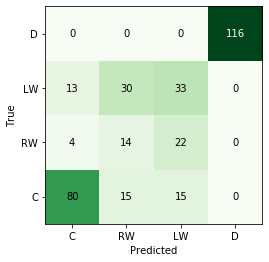

In [44]:
# plot the confusion matrix
cmat, label_list = get_confusion_matrix(test_labels,pred)
fig, ax = plot_confusion_matrix(cmat, label_list)
plt.show()

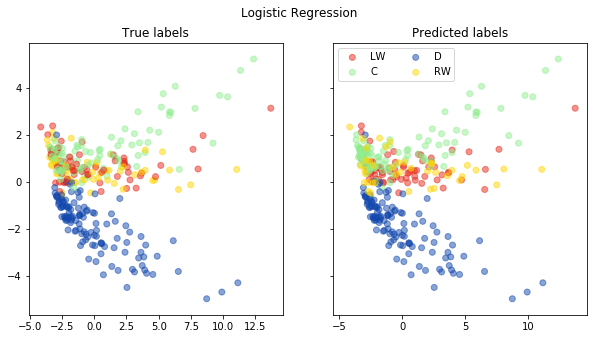

In [45]:
# Plot pred vs. true in a PCA plot
from sklearn.decomposition import PCA

def pca_plot(pred, method):

    # scale the data
    tv = (test_set - test_set.mean()) / test_set.std()

    pca = PCA()
    new_data = pca.fit_transform(tv)

    colors = {
        "RW": "#ffd700",
        "D": "#1348ae",
        "C": "#90ee90",
        "LW": "#e8291c"
    }

    true_labels_to_colors = [ colors[pos] for pos in test_labels ]
    pred_labels_to_colors = np.array([ colors[pos] for pos in pred ])

    fig, ax = plt.subplots(1,2, sharey=True)
    ax[0].scatter(new_data[:,0], new_data[:,1], 
                  alpha = 0.5, 
                  color = true_labels_to_colors)
    
    # 
    for lab in set(pred):
        pos_idx = np.argwhere(pred == lab).flatten()
        ax[1].scatter(new_data[pos_idx,0], new_data[pos_idx,1], 
                      color = pred_labels_to_colors[pos_idx], 
                      alpha = 0.5,
                      label = lab)
    
    
    ax[0].set_title("True labels")
    ax[1].set_title("Predicted labels")
    
    ax[1].legend(loc = 'upper left', ncol = 2)
    
    fig.suptitle(method)
    fig.set_size_inches((10,5))
    fig.patch.set_facecolor((1,1,1))
    
    return fig, ax

fig, ax = pca_plot(pred, "Logistic Regression")

### Random Foest

In [46]:
# let's train a "simple" random forest
rf = RandomForestClassifier()

In [47]:
rf.fit(training_set.values, train_labels)

/Users/jleem/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
pred = rf.predict(test_set.values)
print("Accuracy of random forest is: {}".format(accuracy(np.array(pred), np.array(test_labels))))

Accuracy of random forest is: 0.7076023391812866


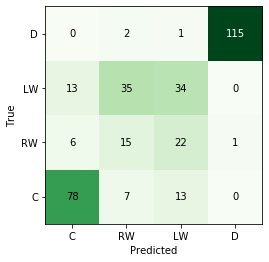

In [49]:
cmat, label_list = get_confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(cmat, label_list)

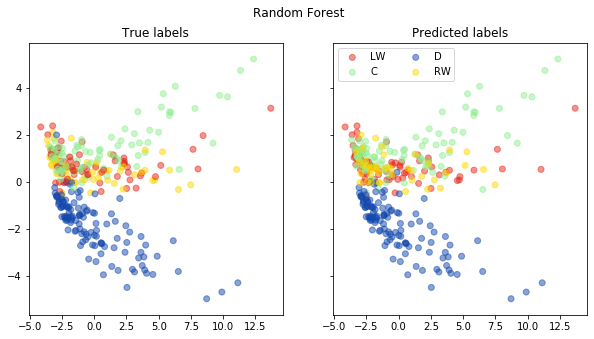

In [51]:
fig, ax = pca_plot(pred, "Random Forest")

### Naive Bayes Classifier

In [24]:
# let's train a "simple" naive bayes classifier
nbc = GaussianNB()

In [25]:
nbc.fit(training_set.values, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
pred = nbc.predict(test_set.values)
print("Accuracy of Naive Bayes classifier is: {}".format(accuracy(np.array(pred), np.array(test_labels))))

Accuracy of Naive Bayes classifier is: 0.5847953216374269


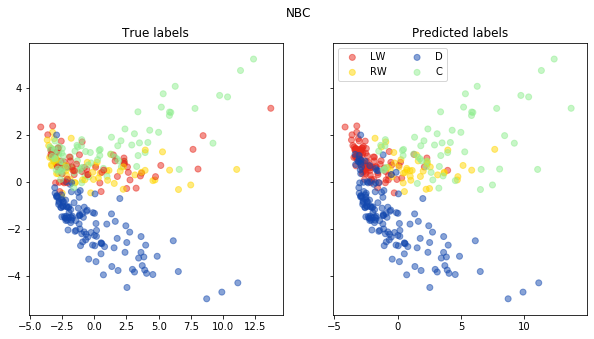

In [27]:
fig, ax = pca_plot(pred, "NBC")

### Support Vector Machines

In [28]:
svc = LinearSVC(max_iter=2000)

In [29]:
svc.fit(training_set.values, train_labels)

/Users/jleem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [30]:
pred = svc.predict(test_set.values)
print("Accuracy of SVC is: {}".format(accuracy(np.array(pred), np.array(test_labels))))

Accuracy of SVC is: 0.7017543859649122


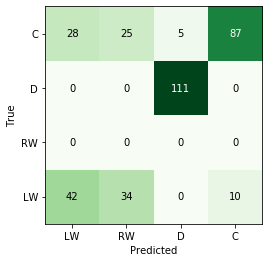

In [31]:
cmat, label_list = get_confusion_matrix(test_labels, pred)
fig, ax = plot_confusion_matrix(cmat, label_list)
plt.show()

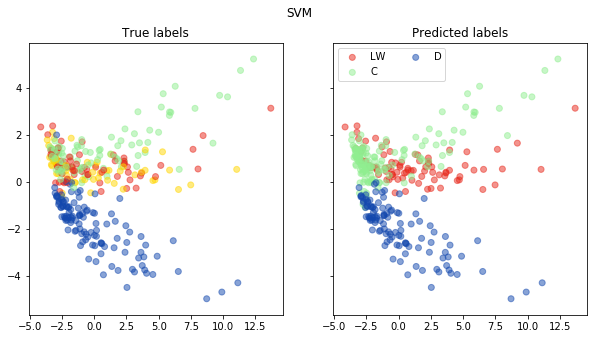

In [32]:
fig, ax = pca_plot(pred, "SVM")

## Revision

No method was a true outstanding performer. While the random forest classifier did have the highest level of accuracy, it was only marginally better than logistic regression.

It would be worth seeing why certain methods failed to classify a player into the correct primary position. We could go more in-depth and ask,
* Is this a case where we over-penalise ourselves (e.g. left-wing vs. right-wing players are not that different)?
* Is this a case where a player has out-of-position behaviours (e.g. a defenseman with some high goals/assists? a forward who is a defensive specialist?)
* Is there not enough game data?

Going further, we can ask...
* Are there fundamental aspects of the ML methods tested here that make it unsuitable for this problem?
* Can we do feature selection of some sort?
* What other information can we get to improve prediction? For example, does stick handed-ness have any bearing on position?

In [40]:
from scipy.stats import gaussian_kde

test_set_copy = test_set.copy()
test_set_copy['pred'] = rf.predict(test_set_copy)

test_to_names = pd.merge(
    left = test_set_copy,
    right = skaters,
    how = 'inner', on = 'player_id'
)

correct = test_to_names[test_to_names['primaryPosition']==test_to_names['pred']].copy()
incorrect = test_to_names[test_to_names['primaryPosition']!=test_to_names['pred']].copy()

incorrect[['firstName', 'lastName', 'primaryPosition', 'pred']]

,firstName,lastName,primaryPosition,pred
1,Teemu,Selanne,RW,LW
6,Todd,Bertuzzi,RW,LW
7,Mike,Grier,RW,C
8,Ryan,Smyth,LW,C
9,Richard,Park,RW,C
...,...,...,...,...
327,Nick,Lappin,RW,LW
328,Patrik,Laine,RW,LW
334,Vinni,Lettieri,C,LW
340,Brady,Tkachuk,LW,RW


Text(0, 0.5, 'Density')

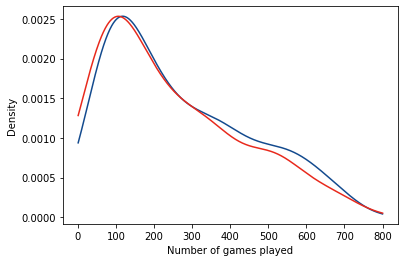

In [38]:
correct_gp = correct['games_played'].values
incorrect_gp = incorrect['games_played'].values

# We can create a Gaussian kernel on top of the number of games played to do some comparisons
correct_kde = gaussian_kde(correct_gp)
incorrect_kde = gaussian_kde(incorrect_gp)

num_games = np.arange(1, 801)

fig, ax = plt.subplots(1,1)
ax.plot(num_games, correct_kde.evaluate(num_games), color = '#134a8e', label = "Correct predictions")
ax.plot(num_games, incorrect_kde.evaluate(num_games), color = '#e8291c', label = "Incorrect predictions")
ax.set_xlabel("Number of games played")
ax.set_ylabel("Density")

What's interesting here is that:
* For the random forest, mis-classifications are only found for forwards (no defensemen are ever classified as forwards and vice-versa).
* There are more winger mis-classifications (actual = RW, predicted = LW), which may imply a too-stringent classification scheme.
* This doesn't seem to be affected by the number of games played by the players as they have similar distributions.

While we can explore the data further to explain misclassifications, I think that's outside the scope of this post and that's for next time...